In [3]:
%matplotlib inline
import numpy as np
import cvxopt
import matplotlib.pyplot as plt
from matplotlib import pylab
from matplotlib import colors
from sklearn.svm import SVC
pylab.rcParams['figure.figsize'] = (10.0, 8.0)
pylab.rcParams['contour.negative_linestyle'] = 'solid'

# No Kernels

In [4]:
X = np.array([[0.5, 2], [1, 1], [1, 3], [3, 1], [3, 3], [3.5, 2]])
y = np.array([1, 1., 1., -1., -1., -1.])

In [6]:
ni, nf = X.shape
X_ = np.matrix(X)
P=cvxopt.matrix(np.outer(y,y)*np.array((X_*X_.T)))
q=cvxopt.matrix(-1*np.ones(ni))
G=cvxopt.matrix(np.diag(-1*np.ones(ni)))
h=cvxopt.matrix(np.zeros(ni))
A=cvxopt.matrix(y, (1, ni))
b=cvxopt.matrix(0.0)

In [7]:
sol=cvxopt.solvers.qp(P, q, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0: -5.7064e-01 -1.3352e+00  8e+00  3e+00  1e+00
 1: -2.2766e-01 -1.2143e+00  1e+00  5e-16  1e-15
 2: -4.5984e-01 -5.4234e-01  8e-02  4e-17  6e-16
 3: -4.9885e-01 -5.0041e-01  2e-03  7e-17  7e-16
 4: -4.9999e-01 -5.0000e-01  2e-05  2e-16  5e-16
 5: -5.0000e-01 -5.0000e-01  2e-07  2e-16  5e-16
Optimal solution found.


In [8]:
alphas = np.ravel(sol['x'])

In [9]:
alphas

array([1.15156864e-07, 2.49999924e-01, 2.49999924e-01, 2.49999924e-01,
       2.49999924e-01, 1.15156864e-07])

In [11]:
sv_inds = np.arange(len(y))[alphas > 1e-5]

In [12]:
w=0
for i in sv_inds:
    w += alphas[i]*X[i]*y[i]

In [14]:
w

array([-9.99999696e-01,  3.33066907e-16])

In [16]:
b = 0
for i in sv_inds:
    b += y[i] - np.dot(w, X[i])
b /= len(sv_inds)

In [17]:
b

1.9999993920737709

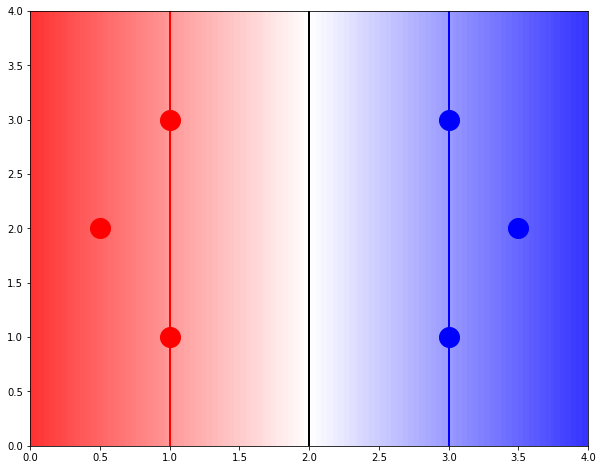

In [18]:
nx = ny = 200
x_min = y_min = 0
x_max = y_max = 4
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
D=np.c_[xx.ravel(), yy.ravel()]
p=np.array([b+np.dot(w, d) for d in D])
p=p.reshape(xx.shape)
plt.pcolormesh(xx, yy, p, cmap='seismic',
                   norm=colors.Normalize(-5, 5))

for i in range(len(X)):
    if y[i] == 1:
        plt.plot(X[i][0], X[i][1], 'o', color='red', markersize=20)
    else:
        plt.plot(X[i][0], X[i][1], 'o', color='blue', markersize=20)
        
plt.contour(xx, yy, p, [0], linewidths=2., colors='k')
plt.contour(xx, yy, p, [1], linewidths=2., colors='r')
plt.contour(xx, yy, p, [-1], linewidths=2., colors='b')

# Kernels

In [19]:
def linear_kernel(x1, x2):
    return np.dot(x1, x2)

In [20]:
def poly_kernel(x1, x2, d=2):
    return (np.dot(x1, x2)+1)**d

In [21]:
def radial_basis_kernel(x1, x2, s):
    return np.exp(-1*(np.dot(x1-x2, x1-x2)/(2*(s**2))))

In [22]:
def tanh_kernel(x1, x2):
    return np.tanh(2*np.dot(x1, x2)+1)

In [23]:
def kernel_matrix(X, kf):
    ns, nf = X.shape
    km = np.zeros((ns, ns))
    for i in range(ns):
        for j in range(ns):
            km[i, j] = kf(X[i], X[j])
    return km

In [24]:
def classify(X, y, alphas, b, kf, x):
    sv_inds = np.arange(len(y))[alphas > 1e-5]
    p=0
    for i in sv_inds:
        p += alphas[i]*y[i]*kf(X[i], x)
    return p+b

In [25]:
def compute_b(X, y, alphas, kf):
    sv_inds = np.arange(len(y))[alphas > 1e-5]
    b=0
    for i in sv_inds:
        b += (y[i] - classify(X, y, alphas, 0, kf, X[i]))
    return b / len(sv_inds)

In [26]:
X = np.array([[1, 1], [1, 3], [3, 1], [3, 3]])
y = np.array([1., -1., -1., 1.])

In [27]:
#kf = linear_kernel
#kf = lambda x1, x2: poly_kernel(x1, x2, 3)
kf = lambda x1, x2: radial_basis_kernel(x1, x2, 10)
#kf = tanh_kernel

In [28]:
ni, nf = X.shape
P=cvxopt.matrix(np.outer(y,y)*kernel_matrix(X, kf))
q=cvxopt.matrix(-1*np.ones(ni))
G=cvxopt.matrix(np.diag(-1*np.ones(ni)))
h=cvxopt.matrix(np.zeros(ni))
A=cvxopt.matrix(y, (1, ni))
b=cvxopt.matrix(0.0)

In [29]:
sol=cvxopt.solvers.qp(P, q, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0: -3.9976e+00 -7.9961e+00  4e+00  4e-16  2e+00
 1: -9.9282e+00 -1.0027e+01  1e-01  6e-16  1e+00
 2:  2.1201e+05 -2.8877e+05  5e+05  1e-11  3e-12
 3:  1.9914e+04 -5.2707e+04  7e+04  2e-12  3e-12
 4: -3.2333e+03 -1.3141e+04  1e+04  2e-12  4e-13
 5: -5.0668e+03 -5.9688e+03  9e+02  2e-12  7e-13
 6: -5.1008e+03 -5.1092e+03  8e+00  5e-13  7e-13
 7: -5.1008e+03 -5.1009e+03  8e-02  8e-13  6e-13
 8: -5.1008e+03 -5.1008e+03  8e-04  8e-13  2e-13
Optimal solution found.


In [30]:
alphas = np.ravel(sol['x'])

In [31]:
b=compute_b(X, y, alphas, kf)

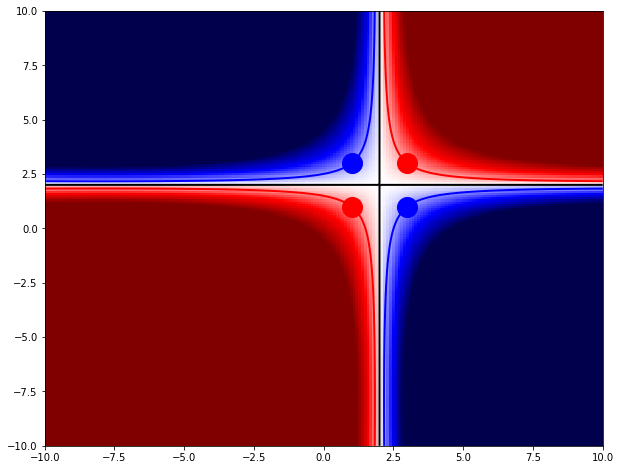

In [32]:
nx = ny = 200
x_min = y_min = -10
x_max = y_max = 10
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
D=np.c_[xx.ravel(), yy.ravel()]
p=np.array([classify(X, y, alphas, b, kf, d) for d in D])
p=p.reshape(xx.shape)
plt.pcolormesh(xx, yy, p, cmap='seismic',
                   norm=colors.Normalize(-5, 5))

for i in range(len(X)):
    if y[i] == 1:
        plt.plot(X[i][0], X[i][1], 'o', color='red', markersize=20)
    else:
        plt.plot(X[i][0], X[i][1], 'o', color='blue', markersize=20)
        
plt.contour(xx, yy, p, [0], linewidths=2., colors='k')
plt.contour(xx, yy, p, [1], linewidths=2., colors='r')
plt.contour(xx, yy, p, [-1], linewidths=2., colors='b')

# Soft-Margin

In [34]:
def compute_b_soft(X, y, alphas, kf, C):
    b=0
    count = 0
    for i in range(len(y)):
        if alphas[i] > 1e-4 and C-alphas[i] > 1e-4:
            b += (y[i] - classify(X, y, alphas, 0, kf, X[i]))
            count += 1
    return b / count

In [35]:
X = np.array([[0.5, 2], [1, 1], [1, 3], [3, 1], [3, 3], [3.5, 2], [3.5, 1]])
y = np.array([1, 1., 1., -1., -1., -1., 1.])

In [36]:
C=100

#kf = linear_kernel
kf = lambda x1, x2: radial_basis_kernel(x1, x2, 1)

ni, nf = X.shape

P=cvxopt.matrix(np.outer(y,y)*kernel_matrix(X, kf))
q=cvxopt.matrix(-1*np.ones(ni))
G=cvxopt.matrix(np.diag(-1*np.ones(ni)))

# a<=C constraints
G = cvxopt.matrix(np.vstack((G, cvxopt.matrix(np.diag(np.ones(ni))))))

h=cvxopt.matrix(np.zeros(ni))

h=cvxopt.matrix(np.vstack((h, cvxopt.matrix(np.ones(ni) * C))))

A=cvxopt.matrix(y, (1, ni))
b=cvxopt.matrix(0.0)

In [37]:
sol=cvxopt.solvers.qp(P, q, G, h, A, b)

     pcost       dcost       gap    pres   dres
 0:  2.8712e+03 -1.4046e+04  2e+04  5e-17  1e-14
 1:  6.5101e+02 -1.0536e+03  2e+03  7e-15  1e-14
 2:  7.6232e+01 -2.0204e+02  3e+02  1e-16  6e-15
 3: -2.8262e+00 -3.5993e+01  3e+01  7e-15  1e-15
 4: -1.1369e+01 -1.5081e+01  4e+00  2e-16  1e-15
 5: -1.2119e+01 -1.2479e+01  4e-01  2e-15  7e-16
 6: -1.2246e+01 -1.2279e+01  3e-02  4e-15  5e-16
 7: -1.2261e+01 -1.2264e+01  3e-03  2e-16  1e-15
 8: -1.2262e+01 -1.2262e+01  2e-04  2e-16  5e-16
 9: -1.2262e+01 -1.2262e+01  4e-06  2e-16  7e-16
Optimal solution found.


In [38]:
alphas = np.ravel(sol['x'])

In [39]:
alphas

array([4.85615741e-08, 1.31548379e+00, 5.13141075e-01, 9.37366560e+00,
       5.79839979e-02, 2.83005831e+00, 1.04330830e+01])

In [40]:
b=compute_b_soft(X, y, alphas, kf, C)

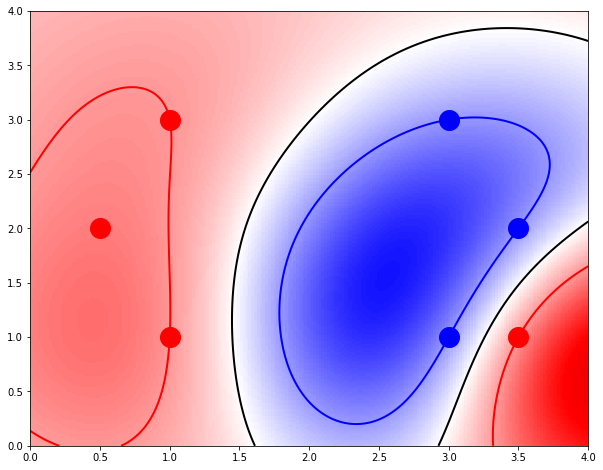

In [41]:
nx = ny = 200
x_min = y_min = 0
x_max = y_max = 4
xx, yy = np.meshgrid(np.linspace(x_min, x_max, nx), np.linspace(y_min, y_max, ny))
D=np.c_[xx.ravel(), yy.ravel()]
p=np.array([classify(X, y, alphas, b, kf, d) for d in D])
p=p.reshape(xx.shape)
plt.pcolormesh(xx, yy, p, cmap='seismic',
                   norm=colors.Normalize(-5, 5))

for i in range(len(X)):
    if y[i] == 1:
        plt.plot(X[i][0], X[i][1], 'o', color='red', markersize=20)
    else:
        plt.plot(X[i][0], X[i][1], 'o', color='blue', markersize=20)
        
plt.contour(xx, yy, p, [0], linewidths=2., colors='k')
plt.contour(xx, yy, p, [1], linewidths=2., colors='r')
plt.contour(xx, yy, p, [-1], linewidths=2., colors='b')